# Active Inference: Optimal control without cost function
In this notebook, we implement [Active inference and agency optimal control without cost functions, Friston et al, 2012](https://link.springer.com/article/10.1007/s00422-012-0512-8). This paper has been fancinating to me for a long time and I was only able to understand it after developing a firm foundation of reinforcement learning, POMDP, control-as-inference, and rereading the paper several times. The "Aha!" moment came when I understood its neuroscience motivation. It's not difficult once you are on the other side -- the only obstacle is the bold claim of "optimal control without cost function", which makes you think about something super profound. I will only implement the "agency-free" version as it is more closely related to later versions of active inference.

A central position held by motor neuroscientists is that humans cannot physiologically represent their own actions. Instead, they predict the consequences of their actions and use reflex to resolve the difference between predictions and the reality. This is known as predictive processing, a closely related topic to active inference. 

## Active inference model and perception-action loop
Given the neuroscience motivation, the question is how to encode such predictions in an agent's model of the environment and how it interacts with perception and action? The paper assumes the agent uses the following model components to operate in a POMDP:
* Observation model $P(o_t|s_t)$
* Transition model $P(s_t|s_{t-1})$
* Reflex model $P(o_t|o_{t-1}, a_{t-1})$

In contrast to the standard POMDP, the agent does not represent actions in the transition model but rather uses an additional reflex model mapping current observation and action to the next observation. The reflex models the idea that the agent predicts the desired **observable** consequences. The transition model encodes the desired transitions. If we have an optimal policy $\pi^{*}(a|s)$ and we know the actual transition $P(s'|s, a)$, the desired transition model can be encoded as $P(s'|s, \pi^{*}) = \sum_{a}P(s'|s, a)\pi^{*}(a|s)$. 

Active inference mandates the agent to minimize a free energy function defined as:
\begin{align}
\begin{split}
\mathcal{F}(o_{1:t}, Q) &= \mathbb{E}_{Q(s_{1:T})}\left[\log Q(s_{1:T}) - \log P(o_{1:t}, s_{1:T})\right]
\end{split}
\end{align}
where $Q(s_{1:T})$ is known as the variational distribution which approximates the posterior distribution of latent states $s_{1:T}$ in approximate Bayesian inference. 

Using a mean field factorization of the variational distribution $Q(s_{1:T}) = \prod_{\tau=1}^{T}Q(s_{\tau})$, the free energy function can be written as:
\begin{align}
\mathcal{F}(o_{1:t}, Q) = \sum_{\tau=1}^{T}\mathbb{E}_{Q(s_{\tau-1}, s_{\tau})}\left[\log Q(s_{\tau}) - \log P(s_{\tau}|s_{\tau-1})\right] - \sum_{\tau=1}^{t}\left[\log P(o_{\tau}|s_{\tau})\right]
\end{align}

Taking the derivative of $\mathcal{F}$ with respect to $Q$ and set to zero, we see that the optimal $Q$ has the form
\begin{align}
Q^{*}(s_{\tau}) = \mathbb{E}_{Q^{*}(s_{\tau-1})}\left[\log P(s_{\tau}|s_{\tau-1})\right] + \mathbb{E}_{Q^{*}(s_{\tau+1})}\left[\log P(s_{\tau+1}|s_{\tau})\right] + \mathbb{I}[\tau \leq t]\log P(o_{\tau}|s_{\tau})
\end{align}

In other words, igorning adjacent time steps, for $\tau \leq t$, the optimal variational distribution approximates exact Bayesian posterior distribution using:
\begin{align}
Q^{*}(s_{\tau}) \propto \mathbb{E}_{Q^{*}(s_{\tau-1})}\left[\log P(o_{\tau}|s_{\tau})P(s_{\tau}|s_{\tau-1}) + c_1\right]
\end{align}
For $\tau > t$, the optimal variational distribution approximates exact Bayesian predictive distribution:
\begin{align}
Q^{*} \propto \mathbb{E}_{Q^{*}(s_{\tau-1})}\left[\log P(s_{\tau}|s_{\tau-1}) + c_2\right]
\end{align}
This constitutes the perceptual behavior of active inference. Namely, perception corresponds to the estimation of unknown past and future hidden states. 

The interesting twist is that action should also minimize free energy. The paper proposes to select action such that the expected free energy associated with the next observation predicted by the reflex models is the lowest. This rule can be written as:
\begin{align}
a_t = \arg\min_{a} \sum_{o_{t+1}}P(o_{t+1}|o_t, a)\mathcal{F}(o_{1:t+1}, Q^{*})
\end{align}
where $\mathcal{F}(o_{1:t+1}, Q^{*})$ is the free energy had the agent observed $o_{t+1}$ in the next time step.

## A non-variational explanation
It might look curious what exactly active inference is doing with this strange setup. 

To answer this question, we will replace the variational belief updates with exact Bayesian belief updates. In contrast with the smoothing scheme in active inference, i.e., belief updates consider observations from all time steps, we will only consider filtering updates, i.e., updating beliefs based on only past observations. We will denote the agent's belief about the current time step as $b = P(s_t|o_{1:t})$. 

Using this setup, for prediction steps $\tau > t$, we have:
\begin{align}
\mathbb{E}_{b(s_{\tau-1}, s_{\tau})}\left[\log \sum_{s}P(s_{\tau}|s_{\tau-1})b(s_{\tau-1}) - \log P(s_{\tau}|s_{\tau-1})\right] \approx 0
\end{align}
For the inference steps $\tau \leq t$, we have:
\begin{align}
\begin{split}
\mathbb{E}_{b(s_{\tau-1}, s_{\tau})}\left[\log \sum_{s}P(s_{\tau}|s_{\tau-1})b(s_{\tau-1}) - \log P(s_{\tau}|s_{\tau-1}) - \log P(o_{\tau}|s_{\tau})\right] \approx -\log P(o_{\tau}|b_{\tau-1})
\end{split}
\end{align}
In other words, the free energy function scores how likeliy $o$ would have been generated if the agent were to act according to an optimal policy. We will thus denote the free energy for the purpose of scoring the next observation as $-\log P(o_{\tau}|\pi^{*})$. 

The control rule can now be written as:
\begin{align}
a_t = \arg\max_{a} \sum_{o_{t+1}}P(o_{t+1}|o_t, a)\log P(o_{t+1}|\pi^{*})
\end{align}
Namely, the agent should choose action with the maximum expected likelihood (or minimum cross entropy) of the resulting observation being generated by an optimal policy.

## Mountain car implementation
We will implement the model in the mountain car environment from Open-AI Gym and compare it against the value iteration solution. The goal for the agent is to swin up the hill and stay at the top with zero velocity. We will make a few modifications to make the implementation and comparison easier. 

First, we will discretize the mountain car observation space into a $20 \times 20$ grid, namely $20$ bins for each observation dimension. We will create a diagonal observation matrix to make the model essentially fully observable. 

Second, we will use the non-variational interpretation. This means we will perform exact Bayesian smoothing and predictions instead of carrying a length 400 matrix or predicting that many steps. 

Lastly, we will construct the reflex matrix from the current belief and the actual transition and observation matices using:
\begin{align}
P(o'|o, a) = \sum_{s}\sum_{s'}P(o'|s')P(s'|s, a)b(s)
\end{align}
where $b(s|o) \propto P(o|s)b(s)$ is the posterior computed using the uniform prior $b(s)$. 

Given these modifications, we can get to work!

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import gym
from gym.envs.classic_control import MountainCarEnv

import torch
import torch.nn as nn
import torch.distributions as torch_dist

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

seed = 123

# set plotting style
strip_size = 12
label_size = 14
mpl.rcParams["axes.labelsize"] = label_size
mpl.rcParams["xtick.labelsize"] = strip_size
mpl.rcParams["ytick.labelsize"] = strip_size
mpl.rcParams["legend.title_fontsize"] = strip_size
mpl.rcParams["axes.titlesize"] = label_size
mpl.rcParams["figure.titlesize"] = label_size

device: cpu


## Create discretized mountain car environment

In [2]:
class CustomMountainCar(MountainCarEnv):
    """ Custom mountain car environment with 
    1. discretization methods
    2. partial observation utilities 
    """
    def __init__(self, x_bins=20, v_bins=20, x_noise=0.1, v_noise=0.01, seed=0):
        """
        Args:
            x_bins (int): number of position bins
            v_bins (int): number of velocity bins
            x_noise (float): position noise for building observation matrix
            v_noise (float): velocity noise for building observation matrix
            seed (int): random seed for noise generation
        """
        super().__init__()
        self.seed = seed
        self.x_bins = x_bins
        self.v_bins = v_bins
        self.state_dim = x_bins * v_bins
        self.act_dim = 3
        self.eps = 1e-6

        self.x_noise = x_noise
        self.v_noise = v_noise
        
        # make reward
        goal_velocity = np.linspace(self.low[1], self.high[1], self.v_bins)
        goal_position = self.goal_position * np.ones_like(goal_velocity)
        goal_obs = np.stack([goal_position, goal_velocity]).T
        goal_state = self.obs2state(goal_obs)
        self.reward = -np.ones((self.state_dim,))
        self.reward[goal_state] = 0

    def batch_step(self, state, action):
        """ Batch apply dynamics 
        
        Args:
            state (np.array): [batch_size, 2]
            action (np.array): [batch_size]
        """
        assert len(list(action.shape)) == 1
        position = state[:, 0].copy()
        velocity = state[:, 1].copy()
        velocity += (action - 1) * self.force + np.cos(3 * position) * (-self.gravity)
        velocity = np.clip(velocity, -self.max_speed, self.max_speed)
        position += velocity
        position = np.clip(position, self.min_position, self.max_position)
        
        # handle min position
        is_invalid = np.stack([position <= self.min_position, velocity < 0]).T
        is_valid = np.all(is_invalid, axis=1) == False
        velocity *= is_valid
        
        next_state = np.stack([position, velocity]).T
        return next_state
    
    def obs2state(self, obs):
        obs = obs.reshape(-1, 2).copy()
        d_x = (self.high[0] - self.low[0]) / self.x_bins
        d_v = (self.high[1] - self.low[1]) / self.v_bins
        x_grid = np.clip((obs[:, 0] - self.low[0]) // d_x, 0, self.x_bins - 1)
        v_grid = np.clip((obs[:, 1] - self.low[1]) // d_v, 0, self.v_bins - 1)
        state = x_grid + v_grid * self.x_bins
        return state.astype(int)

    def state2obs(self, state):
        assert np.all(state <= self.state_dim)
        d_x = (self.high[0] - self.low[0]) / self.x_bins
        d_v = (self.high[1] - self.low[1]) / self.v_bins

        v_grid = np.floor(state / self.x_bins)
        x_grid = state - v_grid * self.x_bins

        position = x_grid * d_x + self.low[0]
        velocity = v_grid * d_v + self.low[1]

        obs = np.stack([position, velocity]).T
        return obs
    
    def make_initial_distribution(self, num_samples=200):
        """ Create initial state distribution """
        np.random.seed(self.seed)
        position = np.random.uniform(-0.6, -0.4, num_samples)
        velocity = np.zeros((num_samples,))
        obs = np.stack([position, velocity]).T
        state = self.obs2state(obs)

        initial_dist = self.eps * np.ones((self.state_dim,))
        unique_state, counts = np.unique(state, return_counts=True)
        initial_dist[unique_state] += counts
        initial_dist /= initial_dist.sum(keepdims=True)
        self.initial_dist = initial_dist

    def make_transition_matrix(self, num_samples=8000):
        """ Create discrete transition marix """
        np.random.seed(self.seed)

        # sample the observation space
        position = np.random.uniform(self.low[0], self.high[0], num_samples)
        velocity = np.random.uniform(self.low[1], self.high[1], num_samples)
        obs = np.stack([position, velocity]).T
        state = self.obs2state(obs)
        
        transition_matrix = self.eps * np.ones((self.act_dim, self.state_dim, self.state_dim))
        for a in range(self.act_dim):
            action = a * np.ones((num_samples,))
            next_obs = self.batch_step(obs, action)
            next_state = self.obs2state(next_obs)
            for s in range(self.state_dim):
                unique_next_state, counts = np.unique(
                    next_state[state == s], return_counts=True
                )
                transition_matrix[a, s, unique_next_state] += counts

        transition_matrix /= transition_matrix.sum(-1, keepdims=True)
        self.transition_matrix = transition_matrix

    def make_observation_matrix(self, num_samples=8000):
        """ Create discrete transition matrix """
        np.random.seed(self.seed)
        # sample the observation space
        position = np.random.uniform(self.low[0], self.high[0], num_samples)
        velocity = np.random.uniform(self.low[1], self.high[1], num_samples)
        obs = np.stack([position, velocity]).T
        state = self.obs2state(obs)

        # sample observations
        x_noise = self.x_noise * np.random.normal(
            np.zeros((num_samples,)), np.ones((num_samples,))
        )
        v_noise = self.v_noise * np.random.normal(
            np.zeros((num_samples,)), np.ones((num_samples,))
        )

        next_position = position + x_noise
        next_velocity = velocity + v_noise
        next_obs = np.stack([next_position, next_velocity]).T
        next_state = self.obs2state(next_obs)

        obs_matrix = self.eps * np.ones((self.state_dim, self.state_dim))
        for s in range(self.state_dim):
            unique_next_state, counts = np.unique(
                next_state[state == s], return_counts=True
            )
            obs_matrix[s, unique_next_state] += counts
        
        obs_matrix /= obs_matrix.sum(-1, keepdims=True)
        self.obs_matrix = obs_matrix

In [3]:
def episode(env, agent, T, verbose=True):
    """ Rollout episode and collect data """
    obs, info = env.reset()
    state = int(env.obs2state(obs))
    
    data = {"obs": [obs], "act": [], "done": []}
    bar = range(T)
    if verbose:
        bar = tqdm(bar)
    for t in bar:
        a = agent.choose_action(state)

        obs, reward, done, truncate, info = env.step(a)
        state = int(env.obs2state(obs))
        
        data["obs"].append(obs)
        data["act"].append(a)
        data["done"].append(done)
    return data

def plot_trajectory(data, figsize=(8, 6)):
    obs = np.stack(data["obs"])
    act = np.stack(data["act"])

    fig, ax = plt.subplots(2, 2, figsize=(8, 6))
    ax = ax.flat
    ax[0].plot(obs[:, 0], obs[:, 1])
    ax[0].plot(obs[0, 0], obs[0, 1], "*", label="start")
    ax[0].plot(obs[-1, 0], obs[-1, 1], "*", label="end")
    ax[0].set_xlabel("position")
    ax[0].set_ylabel("velocity")
    ax[0].legend()

    ax[1].plot(obs[:, 0])
    ax[1].set_xlabel("time")
    ax[1].set_ylabel("position")

    ax[2].plot(obs[:, 1])
    ax[2].set_xlabel("time")
    ax[2].set_ylabel("velocity")

    ax[3].plot(data["act"])
    ax[3].set_xlabel("time")
    ax[3].set_ylabel("action")

    plt.tight_layout()
    return fig, ax

In [4]:
env = CustomMountainCar(x_noise=0., v_noise=0.)
env.make_initial_distribution()
env.make_transition_matrix()
env.make_observation_matrix()

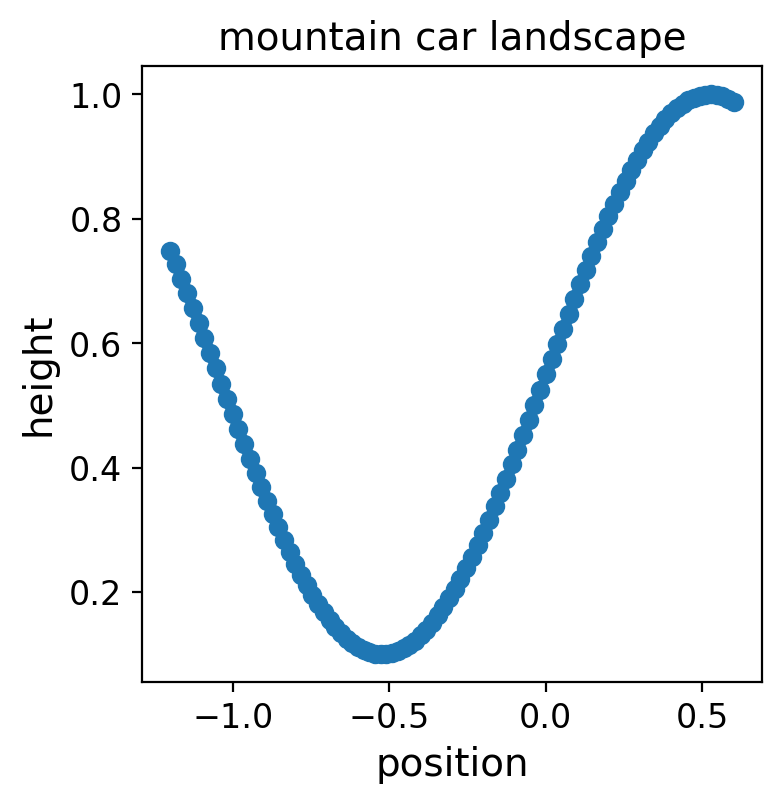

In [5]:
x_grid = np.linspace(-1.2, 0.6, 100)
y = env._height(x_grid)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(x_grid, y, "o")
ax.set_xlabel("position")
ax.set_ylabel("height")
ax.set_title("mountain car landscape")
plt.show()

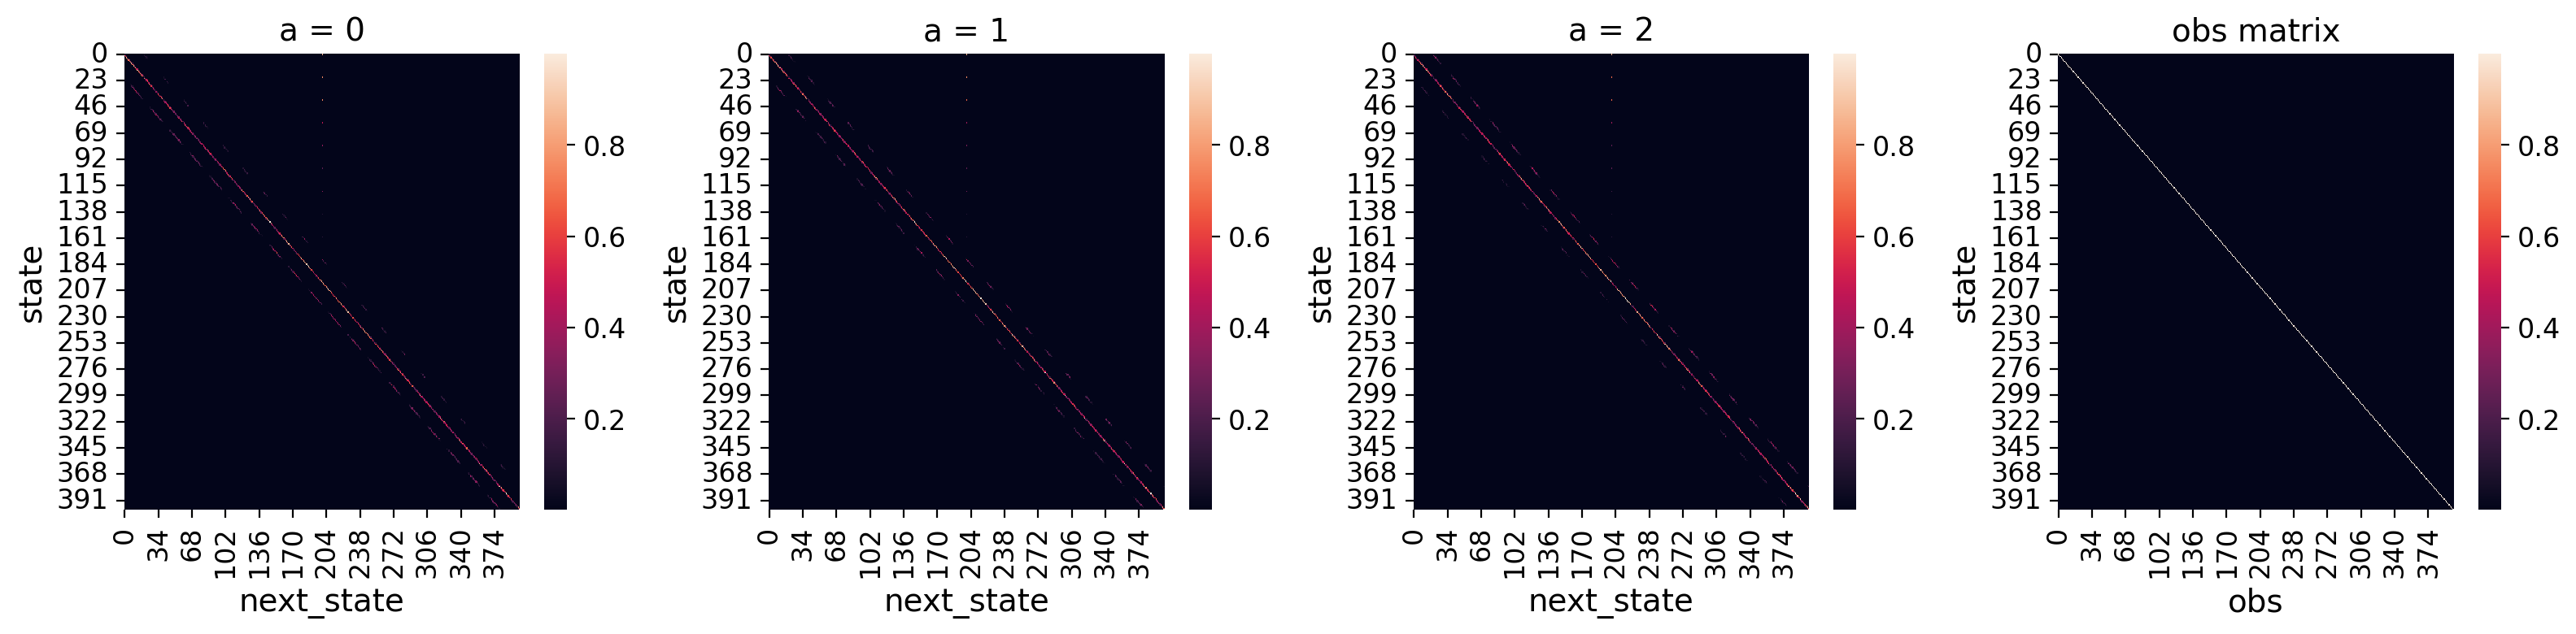

In [6]:
# plot transition and observation matrix
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
for i in range(3):
    sns.heatmap(env.transition_matrix[i], annot=False, cbar=True, ax=ax[i])
    ax[i].set_xlabel("next_state")
    ax[i].set_ylabel("state")
    ax[i].set_title(f"a = {i}")

sns.heatmap(env.obs_matrix, annot=False, cbar=True, ax=ax[3])
ax[3].set_xlabel("obs")
ax[3].set_ylabel("state")
ax[3].set_title("obs matrix")
plt.tight_layout()
plt.show()

## Baseline method

In [7]:
def value_iteration(
    transition_matrix, reward, gamma, softmax=True, 
    alpha=1., max_iter=100, tol=1e-5
    ):
    """
    Args:
        transition_matrix (torch.tensor): transition matrix [act_dim, state_dim, state_dim]
        reward (torch.tensor): reward vector [state_dim]
        gamma (float): discount factor
        softmax (bool): whether to use soft value iteration. Default=True
        alpha (float): softmax temperature
        max_iter (int): max iteration. Default=100
        tol (float): error tolerance for termination. Default=1e-5

    Returns:
        q (torch.tensor): q function [state_dim, act_dim]
        info (dict): {"tol", "iter"}
    """
    state_dim = transition_matrix.shape[1]
    act_dim = transition_matrix.shape[0]
    
    q = [torch.zeros(state_dim, act_dim)]
    for t in range(max_iter):
        if softmax:
            v = torch.logsumexp(alpha * q[t], dim=-1) / alpha
        else:
            v = q[t].max(-1)[0]
        q_t = torch.sum(transition_matrix * (reward + gamma * v).view(1, 1, -1), dim=-1).T
        q.append(q_t)

        q_error = torch.abs(q_t - q[t]).mean()
        if q_error < tol:
            break
    return q[-1], {"tol": q_error.item(), "iter": t}

In [8]:
transition_matrix = torch.from_numpy(env.transition_matrix)
reward = torch.from_numpy(env.reward)

gamma = 0.99 # discount factor
alpha = 10 # softmax temperature
max_iter = 2000
q_soft, info = value_iteration(
    transition_matrix, reward, gamma, softmax=True, alpha=alpha, max_iter=max_iter
)
v_soft = torch.logsumexp(q_soft, dim=-1)
print(f"soft value iteration info: {info}")

soft value iteration info: {'tol': 9.934991580422547e-06, 'iter': 1128}


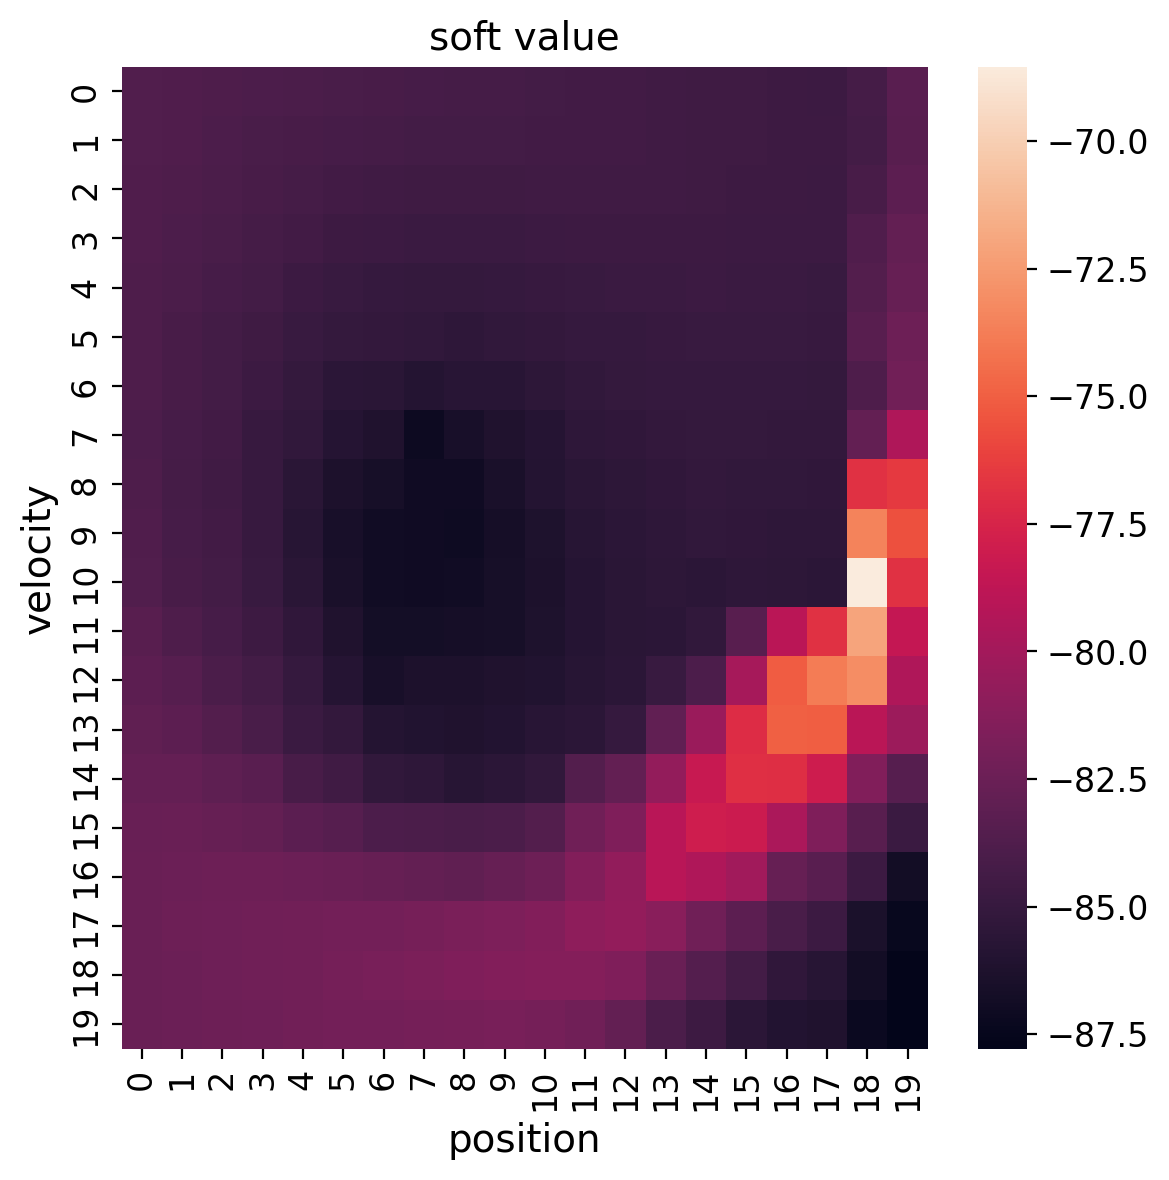

In [9]:
# plot value map
v_soft_map = v_soft.reshape(env.v_bins, env.x_bins)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.heatmap(v_soft_map, annot=False, cbar=True, ax=ax)
ax.set_xlabel("position")
ax.set_ylabel("velocity")
ax.set_title("soft value")

plt.tight_layout()
plt.show()

In [10]:
class MDPAgent(nn.Module):
    """ Tabular policy wrapper """
    def __init__(self, q, beta=1, deterministic=True):
        self.deterministic = deterministic
        self.policy = torch.softmax(beta * q, dim=-1)
    
    def choose_action(self, o):
        pi = self.policy[o]
        
        if self.deterministic:
            a = pi.argmax().item()
        else:
            a = torch.multinomial(pi, 1).item() 
        return a

## Active inference agent

In [11]:
def cross_entropy(p, q, eps=1e-6):
    """ Compute cross entropy -sum p * log(q) """
    logq = torch.log(q + eps)
    ce = -torch.sum(p * logq, dim=-1)
    return ce

In [12]:
class ActionFreeAgent(nn.Module):
    """ Agency-free active inference """
    def __init__(
        self, initial_dist, transition_matrix, obs_matrix, prior_policy     
        ):
        """
        Args:
            initial_dist (torch.tensor): initial state distribution [state_dim]
            transition_matrix (torch.tensor): transition matrix [act_dim, state_dim, state_dim]
            obs_matrix (torch.tensor): observation matrix [state_dim, obs_dim]
            prior_policy (torch.tensor): prior optimal policy [state_dim, act_dim]
        """
        super().__init__()
        self.state_dim = transition_matrix.shape[-1]
        self.act_dim = transition_matrix.shape[1]
        self.obs_dim = obs_matrix.shape[1]
        self.eps = 1e-6
        
        self.initial_dist = initial_dist
        self.transition_matrix = transition_matrix
        self.obs_matrix = obs_matrix
        self.passive_dynamics = torch.einsum("kij, ik -> ij", transition_matrix, prior_policy)
        
        # initial belief
        self.b = initial_dist
    
    def update_belief(self, b, o):
        """ Compute current state estimates

        Args:
            b (torch.tensor): source belief to be updated. size=[..., state_dim]
            o (int): observation index

        Returns:
            b_next (torch.tensor): updated belief. size=[..., state_dim]
        """
        logp_o = torch.log(self.obs_matrix[:, o] + self.eps).view(self.state_dim, -1).T
        logp_s = torch.log(torch.einsum("...i, ij -> ...j", self.b, self.passive_dynamics) + self.eps)
        b_next = torch.softmax(logp_o + logp_s, dim=-1)
        return b_next
    
    def predict(self, b):
        """ Compute next observation distribution according to optimal policy

        Args:
            b (torch.tensor): source belief for prediction. size=[..., state_dim]

        Returns:
            o_next (torch.tensor): observation predictive distribution under optimal policy. size=[..., obs_dim]
        """
        s_next = torch.einsum("...i, ij -> ...j", b, self.passive_dynamics)
        o_next = torch.einsum("...j, jo -> ...o", s_next, self.obs_matrix)
        return o_next
    
    def compute_reflex(self, b):
        """ Compute reflex prediction P(o'|b, a) 
        
        Args:
            b (torch.tensor): current belief. size=[state_dim]

        Returns:
            o_next (torch.tensor): predicted observation probabilities. size=[act_dim, obs_dim]
        """
        s_next = torch.einsum("...i, kij -> ...kj", b, self.transition_matrix)
        o_next = torch.einsum("...kj, jo -> ...ko", s_next, self.obs_matrix)
        return o_next

    def choose_action(self, o):
        # estimate current state
        b_next = self.update_belief(self.b, o)

        # compute reflex observation probabilities
        o_next = self.compute_reflex(self.b)
        
        # compute observation predictive probabilities under optimal policy
        o_next_pi = self.predict(self.b)
        
        # compute expected free energy
        efe = cross_entropy(o_next, o_next_pi)
        
        a = torch.argmin(efe)

        self.b = b_next
        return a.item()

## Mountain car experiment

In [13]:
# action free agent
np.random.seed(seed)
torch.manual_seed(seed)

beta = 1000 # prior policy entropy
env = CustomMountainCar(x_noise=0., v_noise=0.)
env.make_initial_distribution()
env.make_transition_matrix()
env.make_observation_matrix()

initial_dist = torch.from_numpy(env.initial_dist)
transition_matrix = torch.from_numpy(env.transition_matrix)
obs_matrix = torch.from_numpy(env.obs_matrix)
prior_policy = torch.softmax(beta * q_soft, dim=-1)

act_inf_agent = ActionFreeAgent(
    initial_dist, transition_matrix, obs_matrix, prior_policy
)

# run episode
T = 500

act_free_agent_data = episode(env, act_inf_agent, T)

ValueError: cannot reshape array of size 1 into shape (2)

In [14]:
# mdp agent
np.random.seed(seed)
torch.manual_seed(seed)

mdp_agent = MDPAgent(q_soft, beta=100, deterministic=False)

# run episode 
T = 500
env = CustomMountainCar(x_noise=0., v_noise=0.)

mdp_agent_data = episode(env, mdp_agent, T)

ValueError: cannot reshape array of size 1 into shape (2)

In [15]:
fig, ax = plot_trajectory(act_free_agent_data)
ax[0].set_title("action_free_agent")
plt.show()

NameError: name 'act_free_agent_data' is not defined

In [ ]:
fig, ax = plot_trajectory(mdp_agent_data)
ax[0].set_title("mdp_agent")
plt.show()

## Conclusion
The figures above show that the active inference agent is able solve the task, namely swin up the hill and stablize at zero velocity. However, it does so by taking more swins than the MDP agent, thus solving the task with much longer time. 

A likely reason is that we have provided the MDP's optimal policy as the prior policy to the agent. Although this policy is optimal for the MDP, it might not be the optimal prior for the active inference agent's representation of the task. Furthermore, The agent is not robust, i.e., it does not work every run. I have also experimented injecting higher noise into the observation matrix, and this leads to the agent not solving the task at all, most likely for the same reason. In active inference, perception is usually considered strongly coupled to control. In biological system, these two components need to be developed jointly and specifying separately is likely not sufficient for tasks.

The authors of the paper suggested learning the optimal transition directly by marinating the agent in an optimally controlled environment. The optimal transition may further be time dependent. We will not consider this possibility in this notebook.

This notebook is a part of my effort to demystify active inference. To see how active inference were used to learn action-oriented models check out [this notebook](https://www.kaggle.com/code/runway/active-inference-action-oriented-models).